In [1]:
import pandas as pd

from paths import DATA_DIR

df = pd.read_csv(DATA_DIR / 'final_final.csv')

In [2]:
import re
def process(text:str):
    try:
        media_loc = text.split('   ')[0]
        other_text = ' '.join(text.split('   ')[1:])
        if len(media_loc) < len(other_text):
            text = other_text
    except Exception as e:
        media_loc = ''
    text = re.sub(r'\b[sS]\b', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text, media_loc

In [3]:
processed_tuples = [process(f) for f in df.processed_text2.tolist()]
text = [f[0] for f in processed_tuples]
labels = df.label.tolist()

In [4]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
from datasets import Dataset
import torch

data = {"text": text, "label": labels}
dataset = Dataset.from_dict(data)
train_test_split = dataset.train_test_split(test_size=0.2, seed=42)
# train_dataset = train_test_split["train"]
val_dataset = train_test_split["test"]

X_val = val_dataset["text"]
y_val = val_dataset["label"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model_path = "checkpoint-1659"
tokenizer = DistilBertTokenizer.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)
model.to(device)
model.eval()  # Set the model to evaluation mode

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [13]:
from tqdm import tqdm
y_val_pred = []
for text in tqdm(X_val, desc="Evaluating"):
    inputs = tokenizer(
        text,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=-1)

    y_val_pred.append(torch.argmax(probabilities, dim=-1).item())

Evaluating: 100%|██████████| 8836/8836 [06:23<00:00, 23.04it/s]


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

print(f"Acc: {accuracy_score(y_val, y_val_pred)}")
print(f"Prec: {precision_score(y_val, y_val_pred)}")
print(f"Recall: {recall_score(y_val, y_val_pred)}")
print(f"F1: {f1_score(y_val, y_val_pred)}\n\n")

print(classification_report(y_val, y_val_pred))
print(confusion_matrix(y_val, y_val_pred))

Acc: 0.9972838388411046
Prec: 0.9957953749124037
Recall: 0.9985945186226283
F1: 0.9971929824561403


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4567
           1       1.00      1.00      1.00      4269

    accuracy                           1.00      8836
   macro avg       1.00      1.00      1.00      8836
weighted avg       1.00      1.00      1.00      8836

[[4549   18]
 [   6 4263]]


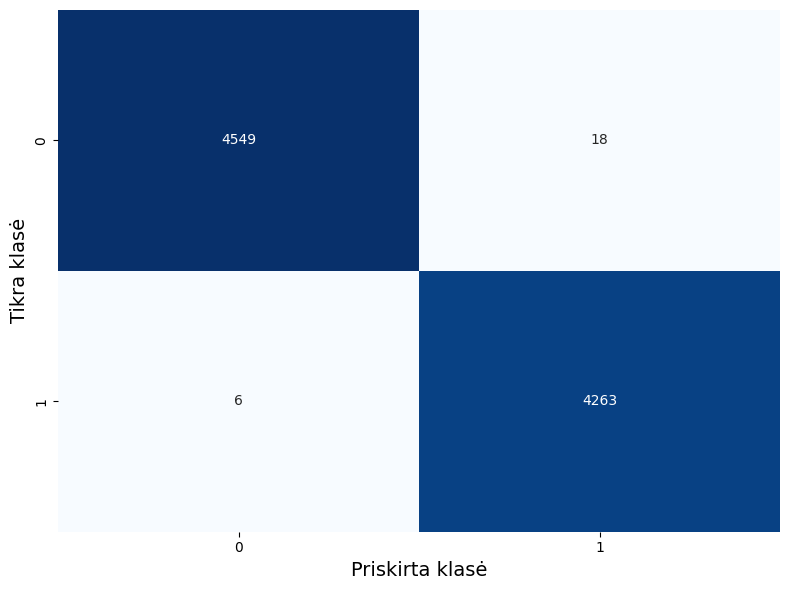

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix values
confusion_matrix = np.array([[4549, 18],
                              [6, 4263]])

# Class labels (adjust as needed)
labels = ["0", "1"]

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels,  cbar=False)

# Add labels and title
plt.xlabel("Priskirta klasė", fontsize=14)
plt.ylabel("Tikra klasė", fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()